In [58]:
%matplotlib ipympl
from impedance.models.circuits import CustomCircuit
from impedance.models.circuits.elements import element
from impedance.visualization import plot_nyquist, plot_bode
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
import pandas as pd
from scipy import stats

In [59]:
def give_weights(z,wt):
    if (wt=="mod"):
        return np.concatenate((np.abs(z),np.abs(z)))
    elif (wt=="prop"):
        return np.concatenate((np.real(z),np.imag(z)))
    elif (wt=="" or wt=="unit"):
        return np.ones(2*len(z))
    
def give_chi_square(zexp,zmodel):
     chi_sqr=np.sum(np.abs((zexp-zmodel))**2)
     return chi_sqr
    
def give_chi_square_wt(zexp,zmodel):
     chi_sqr_wt=np.sum(np.abs((zexp-zmodel))**2/np.abs(zexp)**2)
     return chi_sqr_wt

def give_chi_square_by_N(zexp,zmodel):
     chi_sqr=np.sum(np.abs((zexp-zmodel))**2)
     return np.sqrt((chi_sqr)/len(zexp))

In [60]:
@element(num_params=4, units=["Ohm","Ohm", "F", ""],overwrite=True)
def TLMuni(p, f):
    omega = 2 * np.pi * np.array(f)
    R, Rion, Q, alpha = p[0], p[1], p[2], p[3]
    S=Rion*Q*(1j*omega)**alpha
    Z= R+Rion*np.sqrt(1/(S))*(1/(np.tanh(np.sqrt(S))))
    return Z

@element(num_params=4, units=["Ohm","Ohm", "F", ""],overwrite=True)
def TLMuniEC(p, f):
    omega = 2 * np.pi * np.array(f)
    R, Rion, tau, alpha = p[0], p[1], p[2], p[3]
    S=(1j*omega*tau)**alpha
    Z= R+Rion*np.sqrt(1/S)*(1/(np.tanh(np.sqrt(S))))
    return Z

In [61]:
exp_data=pd.read_excel("abhi experimental through plane data.xlsx",sheet_name="Cal")
exp_data=exp_data.to_numpy()
z_exp_data=exp_data[:,1]+1j*exp_data[:,2]
freq_exp_data=exp_data[:,0]
#freq_exp_data

In [62]:
wt="mod"
c_abhi_data=CustomCircuit(initial_guess=[50,590.6,0.005,1],circuit="TLMuni")
z_inter_abhi=c_abhi_data.predict(freq_exp_data)
give_chi_square_wt(z_exp_data,z_inter_abhi)
give_chi_square_by_N(z_exp_data,z_inter_abhi)

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\impedance\models\circuits\circuits.py:145: UserWarning: Simulating circuit based on initial parameters
  warnings.warn("Simulating circuit based on initial parameters")
C:\Users\admin\AppData\Local\Temp\ipykernel_16244\4034769062.py:6: RuntimeWarning: overflow encountered in tanh
  Z= R+Rion*np.sqrt(1/(S))*(1/(np.tanh(np.sqrt(S))))


608.7437262657692

parameters fit [4.12847284e+01 5.24983440e+02 1.87858908e-03 8.60605570e-01]
Chi2 by mod Z 2 0.09901177005353169
Chi by sqrt(N) 23.523406387558374


C:\Users\admin\AppData\Local\Temp\ipykernel_16244\4034769062.py:6: RuntimeWarning: overflow encountered in tanh
  Z= R+Rion*np.sqrt(1/(S))*(1/(np.tanh(np.sqrt(S))))


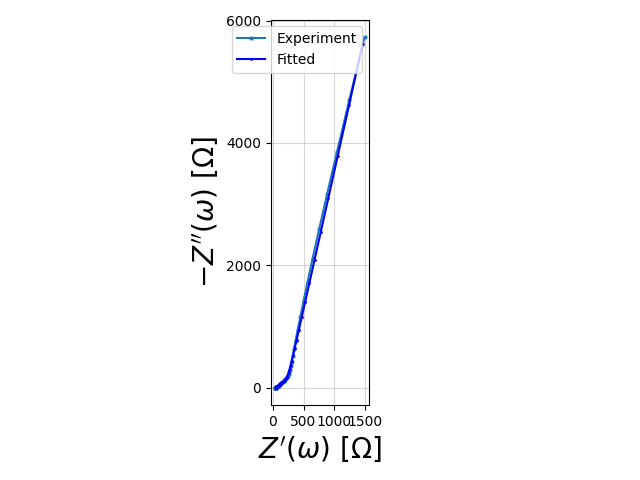

In [63]:

c_fit_abhi=c_abhi_data.fit(freq_exp_data,z_exp_data,sigma=give_weights(z_exp_data,wt=wt),bounds=[(0,0,0,0),(np.inf,np.inf,np.inf,1)])
print("parameters fit",c_fit_abhi.parameters_)

z_pred=c_fit_abhi.predict(freq_exp_data)
fg, ax=plt.subplots()
plot_nyquist(z_exp_data,ax=ax,fmt="-X",ms=2,label="Experiment")
plot_nyquist(z_pred,ax=ax,fmt="-o",color="blue",ms=1,label="Fitted")
ax.legend()
plt.tight_layout()
print("Chi2 by mod Z 2",give_chi_square_wt(z_exp_data,z_pred))
print("Chi by sqrt(N)",give_chi_square_by_N(z_exp_data,z_pred))

# z_pred=np.transpose([np.real(z_pred),np.imag(z_pred)])
# z_pred_df=pd.DataFrame(z_pred)
# z_pred_df.to_excel(f"fitted z-data python on abhi data.xlsx",sheet_name=f"{wt}")


In [64]:
# a=5+56j
# b=89+9j
# EClab=np.abs((a-b))**2
# Our=(np.real(a)-np.real(b))**2+(np.imag(a)-np.imag(b))**2

# print("EClab",EClab)
# #print("|EClab|",np.abs(EClab))
# print("Our",Our)

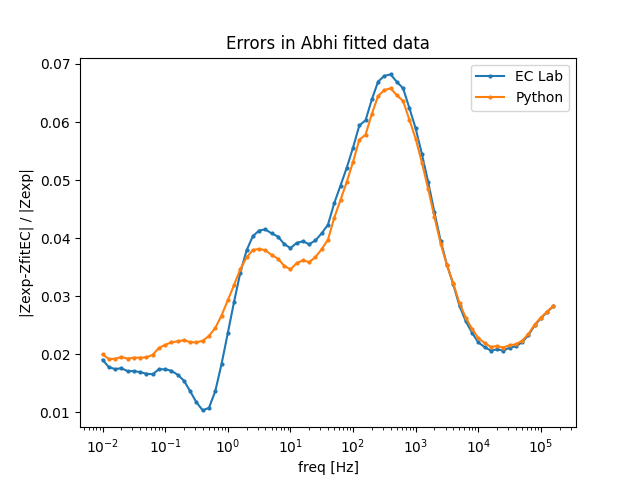

In [94]:
fitted_data=pd.read_excel("compare EC and pyhton on abhi data unit and mod.xlsx",sheet_name="fitted data abhi")
fitted_data=fitted_data.to_numpy()
#print(fitted_data)
z_EC_fitted_data=fitted_data[:,1]+1j*fitted_data[:,2]
z_python_fitted_data=fitted_data[:,3]+1j*fitted_data[:,4]
freq_fitted_data=fitted_data[:,0]
z_EC_error=np.abs(z_exp_data-z_EC_fitted_data)/np.abs(z_exp_data)
z_python_error=np.abs(z_exp_data-z_python_fitted_data)/np.abs(z_exp_data)
fig, axx=plt.subplots()
axx.plot(freq_exp_data,z_EC_error,"-o",ms=2,label="EC Lab")
axx.plot(freq_exp_data,z_python_error,"-o",ms=2,label="Python")
axx.legend()
axx.set_title("Errors in Abhi fitted data")
axx.set_xscale("log")
axx.set_xlabel("freq [Hz]")
axx.set_ylabel("|Zexp-ZfitEC| / |Zexp|")
plt.show()